# Demo of a weighted generative model
An example weighted generative model implementation

- Global optimisation works, but we must tune the nature of how it prunes or strengthens
- Must do step-wise gradient descent and slowly update the communication

In [7]:
# weighted_genereative_model conda environment
# import requirements
import os
import numpy as np
import scipy
from scipy import optimize
import tensorflow as tf
import networkx as nx
import bct as bctpy
import matplotlib.pyplot as plt
import pylab
import copy
import random
from mpl_toolkits.mplot3d import Axes3D
import brainconn as bct

In [8]:
# set network variables
nnode = 20 # number of nodes
xnode = 5 # x axis
ynode = 2 # y axis
znode = 2 # z axis
# compute inputs
Wtgt = np.tril(np.random.randint(0,100,(nnode,nnode)),-1)
Wtgt = (Wtgt+Wtgt.T)
threshold, upper, lower = 90,1,0
Atgt = np.where(Wtgt>threshold,upper,lower)
Aseed = np.zeros((nnode,nnode)) # seed the seed as a random edge that exists
#ind = np.argwhere(Atgt)
#indedge = ind[random.randrange(len(ind)),:]
#Aseed[indedge[0],indedge[1]] = Aseed[indedge[1],indedge[0]] = 1
x = np.arange(xnode) # set the x axis
y = np.arange(ynode) # set the y axis
z = np.arange(znode) # set the z axis
c = np.array(np.meshgrid(x,y,z)).T.reshape(-1,3) # placed in a grid
d = scipy.spatial.distance.pdist(c)
D = scipy.spatial.distance.squareform(d) # euclidean distance matrix
m = int(np.size(np.where(Atgt.flat))/2) # number of connections
eta = np.array([-2]) # eta parameter
gamma = np.array([.5]) # gamma parameter
model_type = 'matching' # generative model
model_var = 'powerlaw' # wiring equation
epsilon = 1e-6

Text(0, 0.5, 'Node')

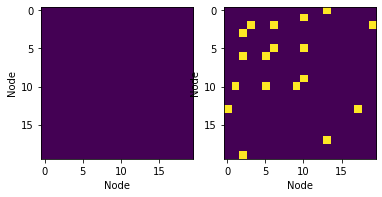

In [9]:
# visualise the seed matrix
subax1 = plt.subplot(121)
plt.imshow(Aseed)
plt.xlabel('Node')
plt.ylabel('Node')
# visualise the target matrix
subax1 = plt.subplot(122)
plt.imshow(Atgt)
plt.xlabel('Node')
plt.ylabel('Node')

In [10]:
# run and example binary generative model
b = bct.generative.generative_model(Aseed, 
                     D, 
                     m, 
                     eta, 
                     gamma, 
                     model_type='matching',
                     model_var='powerlaw', 
                     epsilon=1e-6, 
                     copy=True)

/home/da04/.conda/envs/weighted_generative_model/lib/python3.7/site-packages/brainconn/generative/generative.py:279: RuntimeWarning: divide by zero encountered in power
  Fd = D**eta


(9, 9)

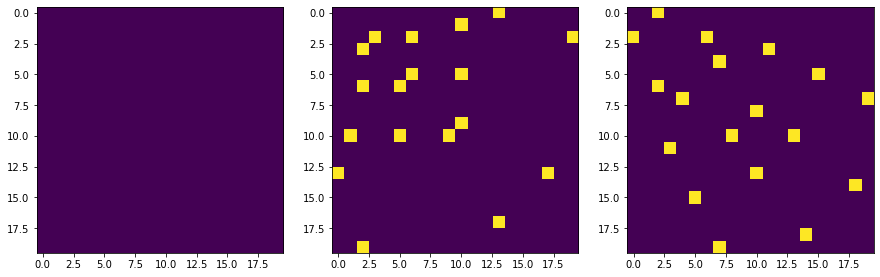

In [11]:
# visualise the binary model
# plot the outcome
plt.figure(figsize=(15,5))
subax1 = plt.subplot(131)
plt.imshow(Aseed)
subax2 = plt.subplot(132)
plt.imshow(Atgt)
subax2 = plt.subplot(133)
plt.imshow(b)
# display the number of edges in target and final network as a sanity check
m,np.size(np.where(b.flat))//2 # number of connections

In [12]:
# define objective function
def objective_function(x):
    # first goal is to minimize communicability
    p = np.reshape(x,(nnode,nnode)) # reshape to a matrix form
    com = scipy.linalg.expm(p) # communicability
    sumcom = np.sum(com) # sum communicability
    # second is to prioritise short edges
    sumd = np.sum(D)
    # return the product of both (update this)
    return sumcom

# set bounds
lbunds = (0,np.inf) # set upper and lower bounds for all existing edges - note, that this could be the change
bnds = ((lbunds,)*np.power(nnode,2)) 
bnds = np.array(bnds)
bnds[b.flatten()==0] = (0,0) # set upper and lower bounds for all non-existing edges

In [13]:
# strength = np.sum(A,axis=1) # get strength
# neg_sqrt = np.power(strength,-0.5) # negative sqrt 
# S = np.diag(neg_sqrt) # diagonalise
# X = S.dot(A).dot(S) # form power term
# X = np.nan_to_num(X,nan=0) # ensure no nan values
# com = scipy.linalg.expm(X) # normalised communicability
# sumcom = np.sum(com) # sum normalised communicability

57.332929444334496


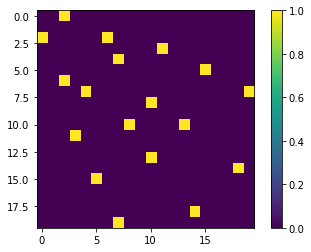

In [14]:
# use an example
plt.imshow(b)
plt.colorbar()
print(objective_function(b.flatten()))

In [15]:
# run the optimizer
solution = optimize.minimize(objective_function,\
                             b.flatten(),\
                             method='SLSQP',\
                             bounds=bnds)
# print solution
print(solution)

/home/da04/.conda/envs/weighted_generative_model/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


     fun: 57.332929444334496
     jac: array([       nan,        nan, 4.23063278,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       4.23063278,        nan,        nan,        nan,        nan,
              nan, 4.23063231,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 2.71

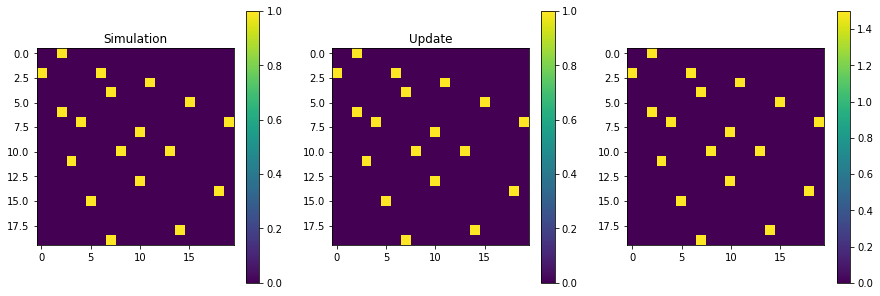

In [16]:
# plot the nework, its optimisation and some weighted combination of the two
plt.figure(figsize=(15,5))
y = np.reshape(solution.x,(nnode,nnode))
subax1 = plt.subplot(131)
plt.imshow(b)
plt.title('Simulation')
plt.colorbar()
subax2 = plt.subplot(132)
plt.imshow(y)
plt.title('Update')
plt.colorbar()
subax3 = plt.subplot(133)
alpha = 0.5
mm = b + alpha*y
plt.imshow(mm)
plt.colorbar()
# note that the optimisation plateuas at the number of nodes! 
# This may give reason to think why we grow networks at all in the first place

In [17]:
# initialise the weighted generative model
alpha = .5 # set the learning rate [0 1]
opt_thr = 10 # set the number of connections before optimisation starts
mi, _, _ = bct.similarity.matching_ind(Aseed) # matching index of the seed
Kseed = mi + mi.T # value matrix of the seed
Kseed += epsilon # add epsilon
mseed = np.size(np.where(Aseed.flat))//2 # compute the number of edges in the seed

In [18]:
# define objective function wihin the generative model
# define objective function
def objective_function(x):
    # first goal is to minimize communicability
    p = np.reshape(x,(nnode,nnode)) # reshape to a matrix form
    com = scipy.linalg.expm(p) # communicability
    sumcom = np.sum(com) # sum communicability
    # second is to prioritise short edges
    sumd = np.sum(D)
    # return the product of both (update this)
    return sumcom

# set bounds
lbunds = (0,np.inf) # set upper and lower bounds for all existing edges - note, that this could be the change
bnds = ((lbunds,)*np.power(nnode,2)) 
bnds = np.array(bnds)
bnds[b.flatten()==0] = (0,0) # set upper and lower bounds for all non-existing edges

In [19]:
# run an example generative model
if type(model_var) == tuple:
    mv1, mv2 = model_var
else:
    mv1, mv2 = model_var, model_var

if mv1 in ('powerlaw', 'power_law'):
    Fd = D**eta
elif mv1 in ('exponential',):
    Fd = np.exp(eta*D)

if mv2 in ('powerlaw', 'power_law'):
    Fk = Kseed**gamma
elif mv2 in ('exponential',):
    Fk = np.exp(gamma*Kseed)
Ffseed = Fd * Fk * np.logical_not(Aseed)
u, v = np.where(np.triu(np.ones((nnode, nnode)), 1)) # get all row column combinations
A = copy.deepcopy(Aseed) # set the new variable
K = copy.deepcopy(Kseed) # set the new variable
Ff = copy.deepcopy(Ffseed) # set the new variable
statement = "From %g seed connections, adding %g connections" % (mseed,m)
print(statement)
for ii in range(mseed,m):
    C = np.append(0, np.cumsum(Ff[u, v]))
    r = np.sum(np.random.random()*C[-1] >= C)
    uu = u[r]
    vv = v[r]
    A[uu, vv] = A[vv, uu] = 1
    updateuu, = np.where(np.inner(A, A[:, uu]))
    np.delete(updateuu, np.where(updateuu == uu))
    np.delete(updateuu, np.where(updateuu == vv))
    c1 = np.append(A[:, uu], A[uu, :])
    for i in range(len(updateuu)):
        j = updateuu[i]
        c2 = np.append(A[:, j], A[j, :])
        
        use = np.logical_or(c1, c2)
        use[uu] = use[uu+nnode] = use[j] = use[j+nnode] = 0
        ncon = np.sum(c1[use]) + np.sum(c2[use])
        if ncon == 0:
            K[uu, j] = K[j, uu] = epsilon
        else:
            K[uu, j] = K[j, uu] = (2 / ncon * np.sum(np.logical_and(c1[use],c2[use])) +epsilon)
    updatevv, = np.where(np.inner(A, A[:, vv]))
    np.delete(updatevv, np.where(updatevv == uu))
    np.delete(updatevv, np.where(updatevv == vv))
    c1 = np.append(A[:, vv], A[vv, :])
    
    for i in range(len(updatevv)):
        j = updatevv[i]
        c2 = np.append(A[:, j], A[j, :])

        use = np.logical_or(c1, c2)
        use[vv] = use[vv+nnode] = use[j] = use[j+nnode] = 0
        ncon = np.sum(c1[use]) + np.sum(c2[use])
        if ncon == 0:
            K[vv, j] = K[j, vv] = epsilon
        else:
            K[vv, j] = K[j, vv] = (2 / ncon * np.sum(np.logical_and(c1[use],c2[use])) +epsilon)

    Fffinal = Fd * Fk * np.logical_not(A)
    
    if ii==mseed: # only after the first edge has been added
        W = copy.deepcopy(A)
        
    # add an optimisation step at a point in the simulation
    if ii>=opt_thr:
        solution = optimize.minimize(objective_function,\
                                     W.flatten(),\
                                     method='SLSQP',\
                                     bounds=bnds)
        tgt = np.reshape(solution.x,(nnode,nnode))
        W = W + alpha*tgt
    
print('Simulation complete')

From 0 seed connections, adding 9 connections
Simulation complete


/home/da04/.conda/envs/weighted_generative_model/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in power
  


(9, 9)

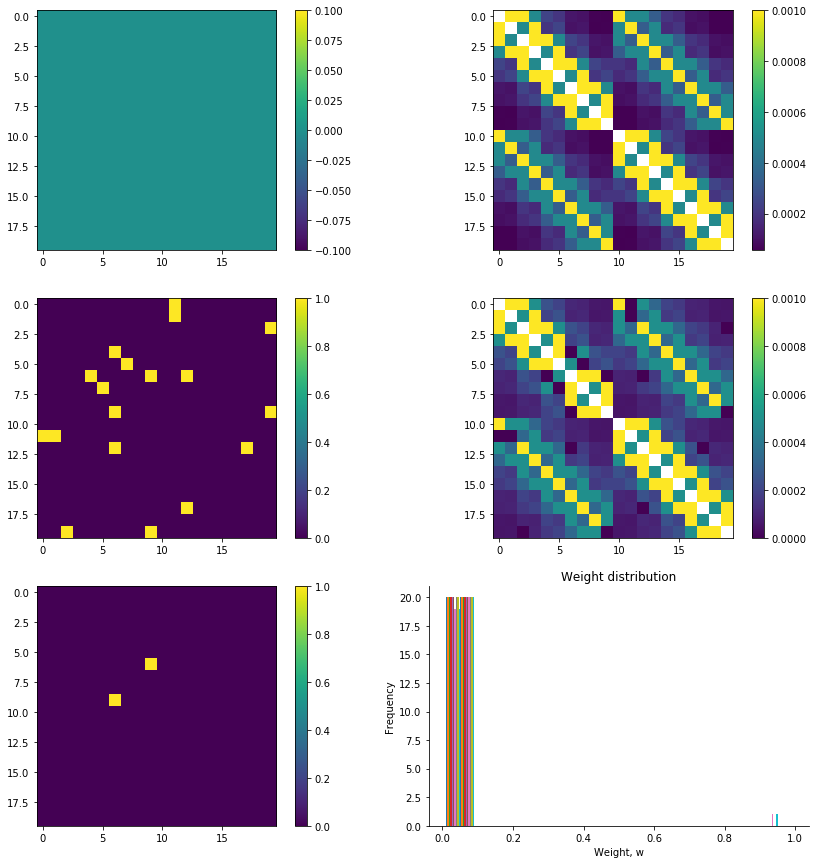

In [20]:
# plot the outcome
plt.figure(figsize=(15,15))
subax1 = plt.subplot(321)
plt.imshow(Aseed)
plt.colorbar()
subax2 = plt.subplot(322)
plt.imshow(Ffseed)
plt.colorbar()
subax3 = plt.subplot(323)
plt.imshow(A)
plt.colorbar()
subax4 = plt.subplot(324)
plt.imshow(Fffinal)
plt.colorbar()
subax5 = plt.subplot(325)
plt.imshow(W)
plt.colorbar()
subax6 = plt.subplot(326)
plt.hist(W)
plt.xlabel('Weight, w')
plt.ylabel('Frequency')
plt.title('Weight distribution')
subax6.spines['top'].set_visible(False)
subax6.spines['right'].set_visible(False)
# display the number of edges in target and final network as a sanity check
m,np.size(np.where(A.flat))//2 # number of connections